# About This Demo

The GPU transcoding and filter module demo shows:
1. Common video/image filters in BMF accelerated by GPU
2. How to write GPU modules in BMF

The demo builds a transcoding pipeline which fully runs on GPU:

decode->scale->flip->rotate->crop->blur->encode




# Get Started

## 1. Environment Setup
*   install the BMF
*   make sure the GPU environment is ready

### 1-1 pip install BMF packages

To install a GPU supported version of BMF:

In [ ]:
!pip uninstall -y BabitMF-GPU
!pip3 install BabitMF-GPU

In [ ]:
%env LIBRARY_PATH=$LIBRARY_PATH:/usr/local/lib/python3.10/dist-packages/bmf/lib

### 1-2 verify the FFmpeg libraries is installed and version is correct

Part of feature in BMF framework utilizes the FFmpeg demuxer/muxer/codec and filter as the built-in modules for video processing. **If the capability of ffmpeg is needed,it's neccessary for users to install supported FFmpeg libraries before using BMF.**

**Optional step**

Install ffmpeg and related libraries. For this demo, we don't have to do this step, because ffmpeg libraries are already installed in the Google Colab environment.

In [ ]:
!sudo apt install ffmpeg

List the ffmpeg libraries. It is expected that the related libraries such libavcodec, libavformat are installed. The output should be showned as below:
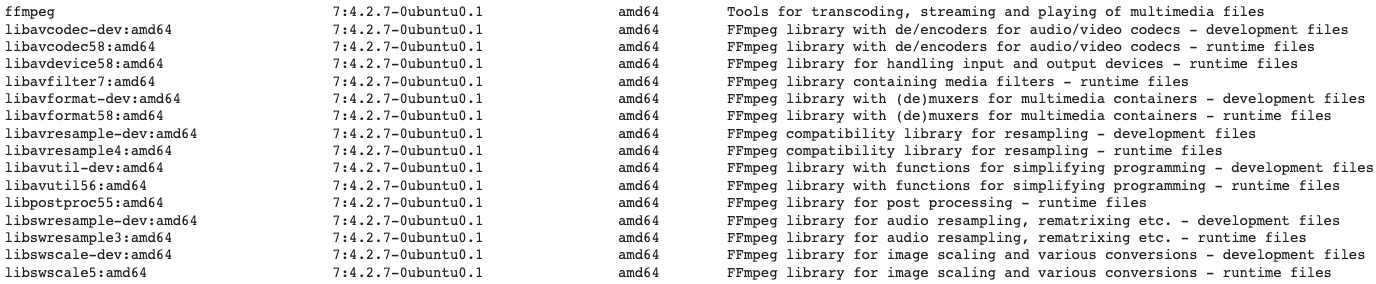

In [ ]:
!sudo apt install libdw1

In [ ]:
!dpkg -l | grep -i ffmpeg

Display the FFmpeg version. **BMF supports the FFmpeg verions above 4.2.x.**

In [ ]:
!ffmpeg -version

### 1-3 install CV-CUDA

The GPU modules are implemented using CV-CUDA, **it's necessary to install CV-CUDA if you want to run the modules.**

To install CV-CUDA, we need to collect the pre-built binaries from github then install them using apt.

In [ ]:
!wget https://github.com/CVCUDA/CV-CUDA/releases/download/v0.3.1-beta/nvcv-lib-0.3.1_beta-cuda12-x86_64-linux.deb
!wget https://github.com/CVCUDA/CV-CUDA/releases/download/v0.3.1-beta/nvcv-dev-0.3.1_beta-cuda12-x86_64-linux.deb
!wget https://github.com/CVCUDA/CV-CUDA/releases/download/v0.3.1-beta/nvcv-python3.10-0.3.1_beta-cuda12-x86_64-linux.deb
!wget https://github.com/CVCUDA/CV-CUDA/releases/download/v0.3.1-beta/nvcv_python-0.3.1_beta-cp310-cp310-linux_x86_64.whl

!sudo apt install ./nvcv-lib-0.3.1_beta-cuda12-x86_64-linux.deb ./nvcv-dev-0.3.1_beta-cuda12-x86_64-linux.deb ./nvcv-python3.10-0.3.1_beta-cuda12-x86_64-linux.deb

Verify that CV-CUDA has been installed properly.

In [ ]:
import cvcuda
print(cvcuda.__version__)

### 1-3 install wurlitzer

This package is installed to show the BMF C++ logs in the colab console, otherwise only python logs are printed. This step is not necessary if you're not in a Colab or iPython notebook environment.

In [ ]:
!pip install wurlitzer
%load_ext wurlitzer

## 2. BMF GPU Transcoding & Filter Demo
 Now let's set up a gpu transcoding pipeline with common filters. The pipeline will be complete run on GPU, which means the data does not need to be copied back to CPU. We should always avoid CPU-GPU data movement as much as possible, this is an important practice in terms of performance.

### 2-1 Fetch code from github


In [ ]:
!git clone https://github.com/BabitMF/bmf.git
%cd bmf/bmf/demo/gpu_module

### 2-1 Fetch test video from bmf repo



In [ ]:
!wget https://github.com/BabitMF/bmf/releases/download/files/files.tar.gz
!tar -zvxf files.tar.gz
!cp files/big_bunny_10s_30fps.mp4 .

### 2-2 Run the demo

The example GPU modules are implemented in the following files:

*   scale_gpu.py
*   flip_gpu.py
*   rotate_gpu.py
*   crop_gpu.py
*   blur_gpu.py

You can tell what the module does by its name. Please refer to `bmf/bmf/docs/example/Example_GpuModule.md` for detailed documentation of the GPU modules. Now let's run these modules using the following Python script


In [ ]:
import bmf

def test():
    input_video_path = "./big_bunny_10s_30fps.mp4"
    output_path = "./output.mp4"

    graph = bmf.graph()
    video = graph.decode({
        "input_path": input_video_path,
        "video_params": {
            "hwaccel": "cuda"
        }
    })
    (
        video['video']
            .module('scale_gpu', {"size": '1920x1080', 'algo': 'cubic'})
            .module('crop_gpu', {'x': 960, 'y': 540, 'width': 480, 'height': 480})
            .module('flip_gpu', {'direction': 'h'}) # direction can be 'vertical', 'h', 'horizontal' or 'both'
            .module('rotate_gpu', {'angle': 'pi/8'})
            .module('blur_gpu', {'op': 'gblur', 'sigma': [0.7, 0.7], 'size': [5, 5]})
            .encode(None, {
                "output_path": output_path,
                "video_params": {
                    "codec": "hevc_nvenc",
                    "pix_fmt": "cuda",
                }
            })
            .run()
    )


if __name__ == '__main__':
    test()


Display the input and output video streams:

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 800):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
# show output video
show_video("./big_bunny_10s_30fps.mp4")

In [ ]:
# show output video
show_video("./output.mp4")